In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing the trained model

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tqdm.auto import tqdm

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils
import dm_pix as pix

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-04-12 13:00:54.309760: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 13:00:54.338972: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 13:00:54.339614: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 13:00:54.845196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-04-12 13:00:55.715405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do

In [2]:
# jax.config.update("jax_debug_nans", False)

In [3]:
import matplotlib.pyplot as plt

In [4]:
id = "9wt4n5j8" # Baseline

In [5]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_JaX/{id}")

In [6]:
config = ConfigDict(prev_run.config["_fields"])

In [7]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [8]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(inputs)
        outputs = nn.Conv(features=3, kernel_size=(1,1), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=6, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=128, kernel_size=(5,5), strides=1, padding="SAME")(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [9]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [10]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [11]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [12]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [13]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [14]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [15]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

2024-04-12 13:01:10.265782: W external/xla/xla/service/gpu/nvptx_compiler.cc:596] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [16]:
import flax

In [17]:
def check_trainable(path):
    return False
    # return ("A" in path) or ("alpha_achrom" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [18]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [19]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [20]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [21]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Instantiate the checkpointer to reload the already trained model:

In [22]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [23]:
state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)

In [24]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

36368

## Obtaining the receptive field

In [25]:
from functools import partial

In [26]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [27]:
def rmse(a, b):
    return jnp.sqrt(jnp.mean((a-b)**2, axis=(1,2,3)))

In [28]:
@jax.jit
def compute_distance(state, img1, img2):
    def forward(state, inputs): return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)
    pred_1 = forward(state, img1)
    pred_2 = forward(state, img2)
    return rmse(pred_1, pred_2)

In [39]:
IMG_SIZE = (1, 256, 256, 3)
BORDER = 4
FILTER_IDX = 3
NOISE_VAR = 0.25
try:
    filt = state.params["Conv_2"]["kernel"][...,0,FILTER_IDX]
    print("Gabor")
except:
    filt = state.params["Conv_1"]["kernel"][...,0,FILTER_IDX]
    print("Center Surround")
filt.shape

Gabor


(5, 5)

Define the optimization loop:

In [40]:
@partial(jax.jit, static_argnums=(1))
def optim_step(state, tx, tx_state, img):
    def loss_fn(img):
        def forward(state, inputs): return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)
        pred = forward(state, img)
        b, h, w, c = pred.shape
        return -(pred[...,BORDER:h-BORDER, BORDER:w-BORDER, FILTER_IDX]**2).mean() # Change sign because we want to maximize
    loss, grads = jax.value_and_grad(loss_fn)(img)
    updates, tx_state = tx.update(grads, tx_state)
    img = optax.apply_updates(img, updates=updates)
    return img, loss, tx_state

In [41]:
EPOCHS = 20000
LEARNING_RATE = 3e-4
name = "PerceptNet"

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

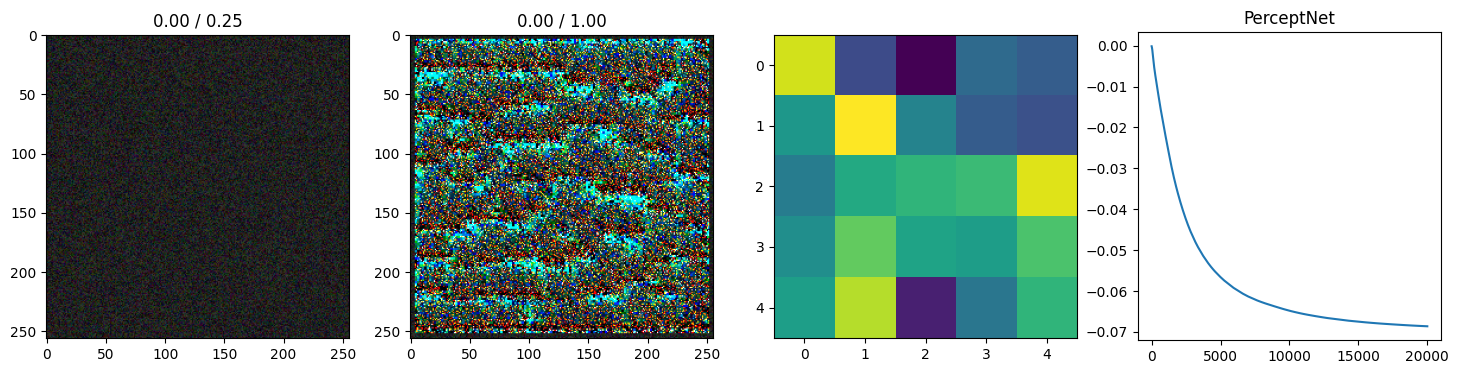

In [42]:
final_imgs = []
for FILTER_IDX in tqdm(range(state.params["Conv_2"]["kernel"].shape[-1])):
    # Generate the input image
    img = NOISE_VAR*random.uniform(random.PRNGKey(42), shape=IMG_SIZE)

    ## Initialize optimizer state
    tx = optax.adam(learning_rate=LEARNING_RATE)
    tx_state = tx.init(img)
    imgs = [jax.device_put(img, jax.devices("cpu")[0])]
    losses = []

    ## Optimize the image
    for epoch in tqdm(range(EPOCHS), leave=False):
        img, loss, tx_state = optim_step(state, tx, tx_state, img)

        img = jnp.clip(img, a_min=0., a_max=1.)
        imgs.append(jax.device_put(img, jax.devices("cpu")[0]))
        losses.append(loss)

    ## Plot the result
    fig, axes = plt.subplots(1,4, figsize=(18,4))
    axes[0].imshow(imgs[0][0])
    axes[1].imshow(img[0])
    axes[2].imshow(state.params["Conv_2"]["kernel"][...,0,FILTER_IDX])
    axes[3].plot(losses)
    axes[0].set_title(f"{imgs[0].min():.2f} / {imgs[0].max():.2f}")
    axes[1].set_title(f"{img.min():.2f} / {img.max():.2f}")
    axes[3].set_title(name)
    # break
    ## Save the figure
    plt.savefig(f"Receptive_Fields/optim_result_{FILTER_IDX}.png", dpi=300)
    plt.show()

    ## Store the final images
    final_imgs.append(imgs[-1])

In [70]:
from pickle import dump
with open("Receptive_Fields/final_imgs.pkl", "wb") as f:
    dump(final_imgs, f)

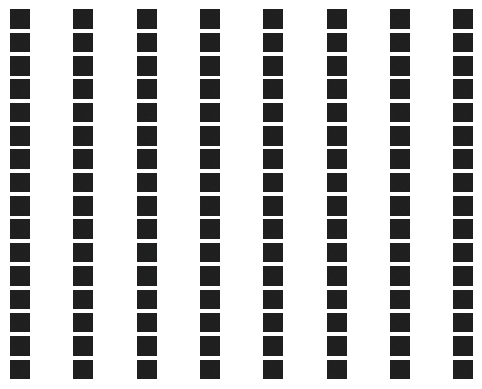

In [71]:
fig, axes = plt.subplots(16,8)
for rf, ax in zip(final_imgs, axes.ravel()):
    ax.imshow(rf[0])
    ax.axis("off")
plt.savefig("Receptive_Fields/final_imgs_mosaic.png", dpi=300)
plt.show()